# Barcelona Bicycle Station Analysis and Prediction



## Objective

This notebook aims to analyze data from Barcelona's bicycle stations and the percentage of free docks at a given time based on historical data.



## Data Sources

We have two datasets:

1. Historical data - Contains time-series information about station status

2. Station data - Contains static information about each station



We'll merge these datasets to create a comprehensive view for our analysis.

## 1. Import Libraries

In [11]:
# Data manipulation and analysis

import pandas as pd
import numpy as np
import os

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
import folium
from folium.plugins import HeatMap

# Date and time handling

from datetime import datetime, timedelta

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## 2. Load and Prepare Data



### 2.1 Download Historical Data

In [ ]:
# Load final dataset

try:
    complete_data = pd.read_csv('data/historical_data.csv')
    print(f"Final data loaded successfully with {complete_data.shape[0]} rows and {complete_data.shape[1]} columns")
except FileNotFoundError:
    print("Station data file not found. Creating sample data for demonstration...")

Final data loaded successfully with 18209862 rows and 13 columns


### 2.2 Filter only by years 2020, 2021, 2022 and 2023

In [42]:
complete_data = complete_data[complete_data['year'].isin([2020, 2021, 2022, 2023])]


## 3. Explore data

In [36]:
# === Step 1: Aggregate usage by station ===
# Let's assume usage = 1 - average free_docks_percentage
station_usage = complete_data.groupby(['station_id', 'lat', 'lon']).agg({
    'free_docks_percentage': 'mean'
}).reset_index()

station_usage['usage'] = station_usage['free_docks_percentage']

# === Step 2: Create a base map centered in Barcelona ===
barcelona_location = [41.3851, 2.1734]  # Barcelona coordinates
m = folium.Map(location=barcelona_location, zoom_start=13, tiles='CartoDB positron')

# === Step 3: Prepare heatmap data ===
heat_data = [
    [row['lat'], row['lon'], row['usage']] for index, row in station_usage.iterrows()
]

# === Step 4: Add Heatmap layer ===
HeatMap(heat_data, radius=15, blur=10, max_zoom=1).add_to(m)

# === Step 5: Display the map ===
m.save('bike_usage_heatmap.html')
print("Heatmap saved to bike_usage_heatmap.html")

Heatmap saved to bike_usage_heatmap.html


## 4. Comprehensive Bike Usage Analysis in Barcelona

In this section, we'll perform a detailed analysis of bike usage patterns in Barcelona, exploring temporal, spatial, and other factors that influence bike availability.

### 4.1 Data Overview and Preparation

Let's first ensure our data is properly prepared for analysis:

In [70]:
# Calculate bike usage (equal to free docks percentage, if dock is free the bike is being used)
complete_data['usage_percentage'] = complete_data['free_docks_percentage']

# Create datetime column for easier time-based analysis
complete_data['datetime'] = pd.to_datetime(complete_data[['year', 'month', 'day', 'hour']])

### 4.2 Temporal Analysis

#### 4.2.1 Hourly Usage Patterns

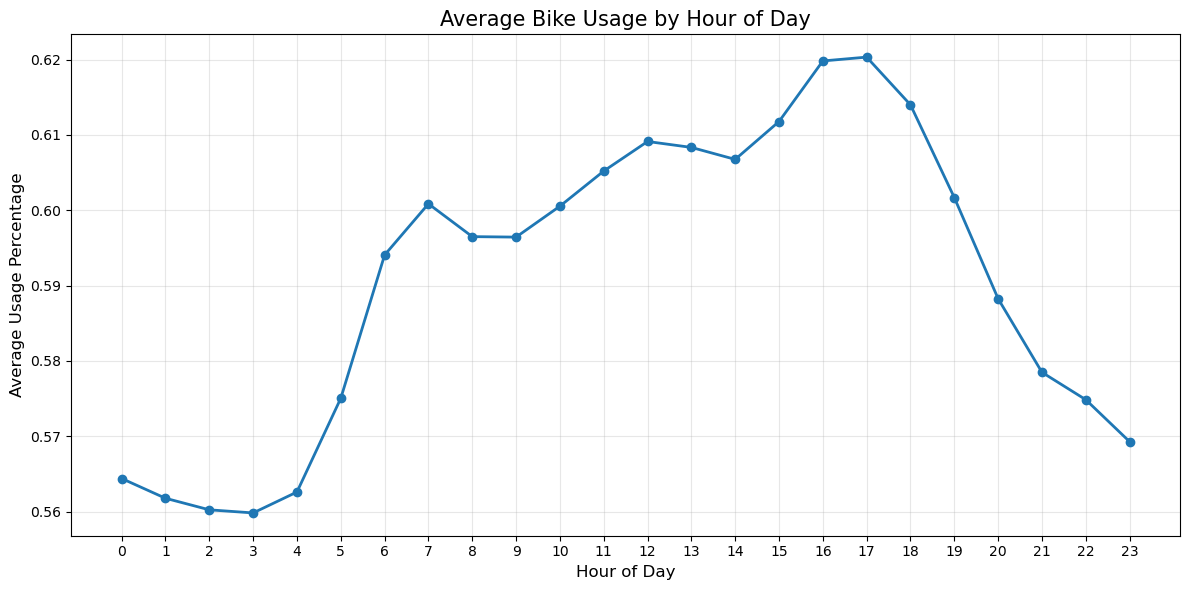

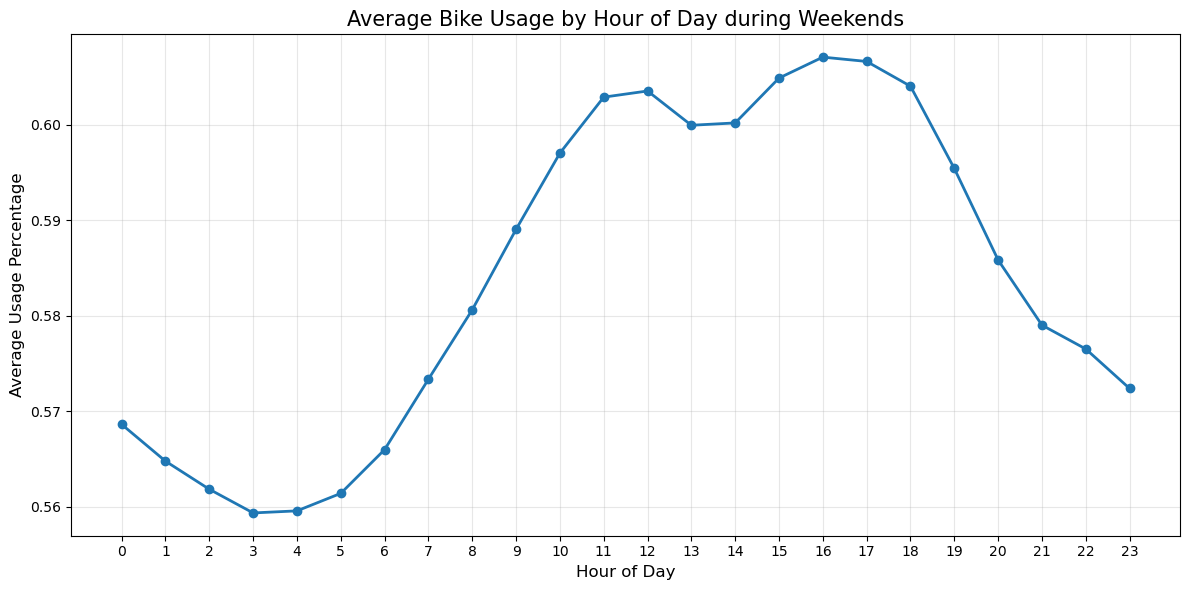

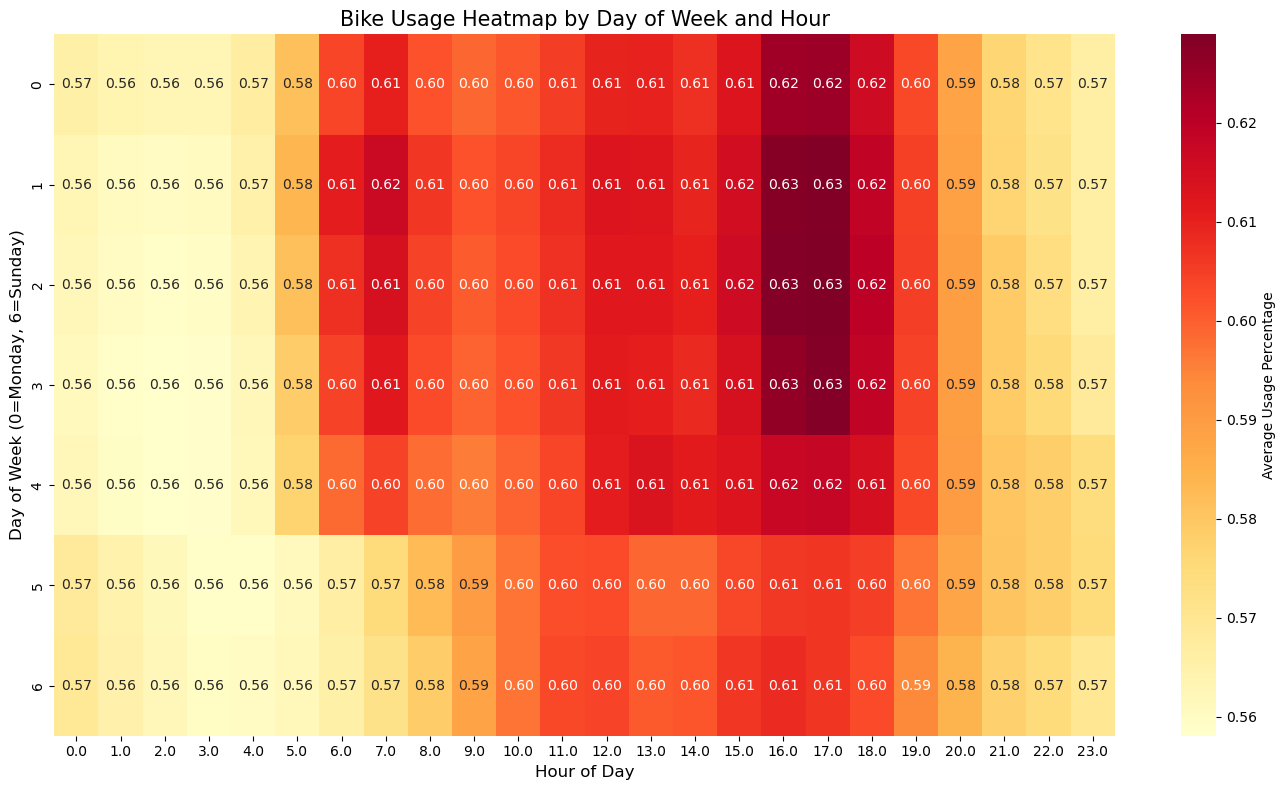

In [71]:
# Analyze hourly patterns
hourly_usage = complete_data.groupby('hour')['usage_percentage'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(hourly_usage['hour'], hourly_usage['usage_percentage'], marker='o', linewidth=2)
plt.title('Average Bike Usage by Hour of Day', fontsize=15)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Average Usage Percentage', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Analyze hourly patterns in weekends
hourly_usage_weekend = complete_data[complete_data['is_weekend'] == 1]
hourly_usage_weekend = hourly_usage_weekend.groupby('hour')['usage_percentage'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(hourly_usage_weekend['hour'], hourly_usage_weekend['usage_percentage'], marker='o', linewidth=2)
plt.title('Average Bike Usage by Hour of Day during Weekends', fontsize=15)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Average Usage Percentage', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



# Create a heatmap showing hourly usage by day of week
hourly_dow_usage = complete_data.groupby(['day_of_week', 'hour'])['usage_percentage'].mean().unstack()

plt.figure(figsize=(14, 8))
sns.heatmap(hourly_dow_usage, cmap='YlOrRd', annot=True, fmt='.2f', cbar_kws={'label': 'Average Usage Percentage'})
plt.title('Bike Usage Heatmap by Day of Week and Hour', fontsize=15)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Day of Week (0=Monday, 6=Sunday)', fontsize=12)
plt.tight_layout()
plt.show()

#### 4.2.2 Daily and Weekly Patterns

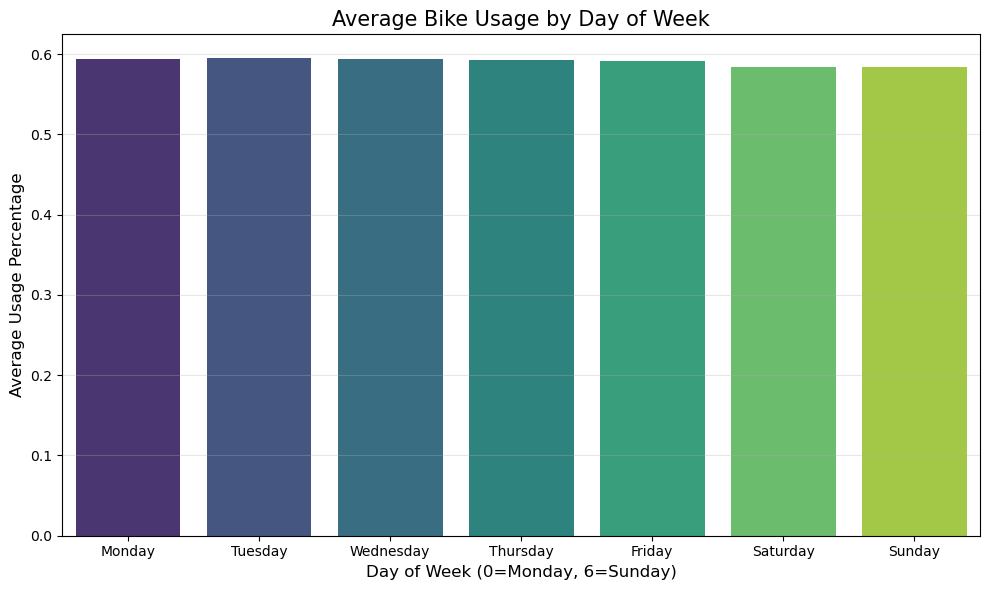

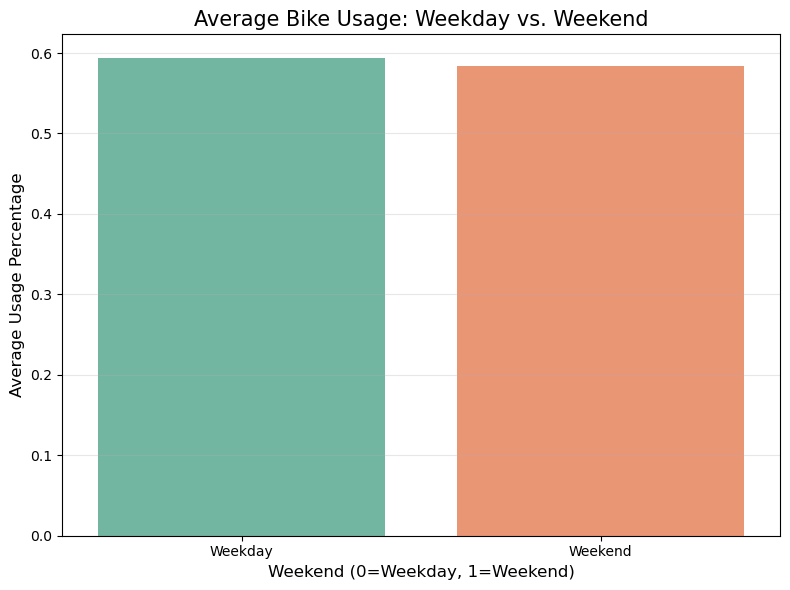

In [72]:
# Daily patterns
daily_usage = complete_data.groupby('day_of_week')['usage_percentage'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='usage_percentage', data=daily_usage, palette='viridis')
plt.title('Average Bike Usage by Day of Week', fontsize=15)
plt.xlabel('Day of Week (0=Monday, 6=Sunday)', fontsize=12)
plt.ylabel('Average Usage Percentage', fontsize=12)
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Weekend vs. Weekday comparison
weekend_comparison = complete_data.groupby('is_weekend')['usage_percentage'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='is_weekend', y='usage_percentage', data=weekend_comparison, palette='Set2')
plt.title('Average Bike Usage: Weekday vs. Weekend', fontsize=15)
plt.xlabel('Weekend (0=Weekday, 1=Weekend)', fontsize=12)
plt.ylabel('Average Usage Percentage', fontsize=12)
plt.xticks([0, 1], ['Weekday', 'Weekend'])
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

#### 4.2.3 Monthly and Seasonal Patterns

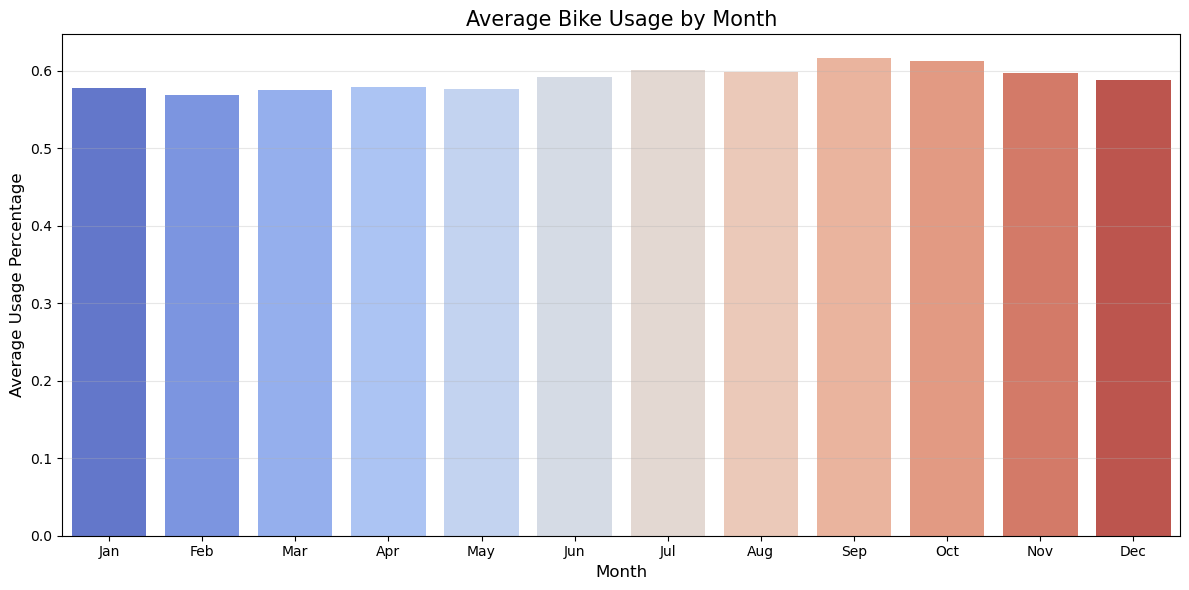

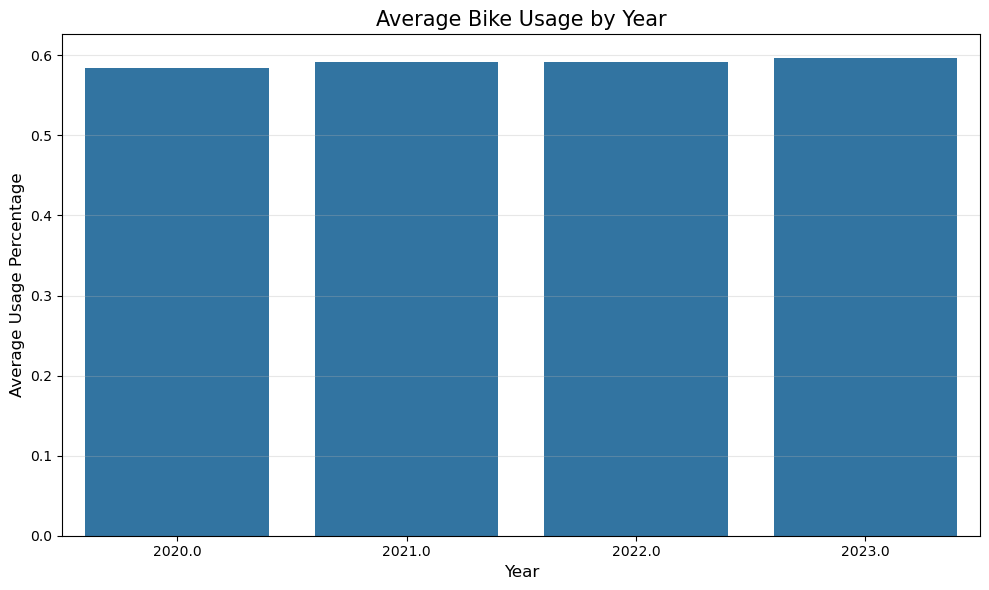

In [73]:
# Monthly patterns
monthly_usage = complete_data.groupby('month')['usage_percentage'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='month', y='usage_percentage', data=monthly_usage, palette='coolwarm')
plt.title('Average Bike Usage by Month', fontsize=15)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Usage Percentage', fontsize=12)
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Yearly comparison
yearly_usage = complete_data.groupby('year')['usage_percentage'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='year', y='usage_percentage', data=yearly_usage)
plt.title('Average Bike Usage by Year', fontsize=15)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Usage Percentage', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### 4.3 Spatial Analysis

#### 4.3.1 Usage by Distance from City Center

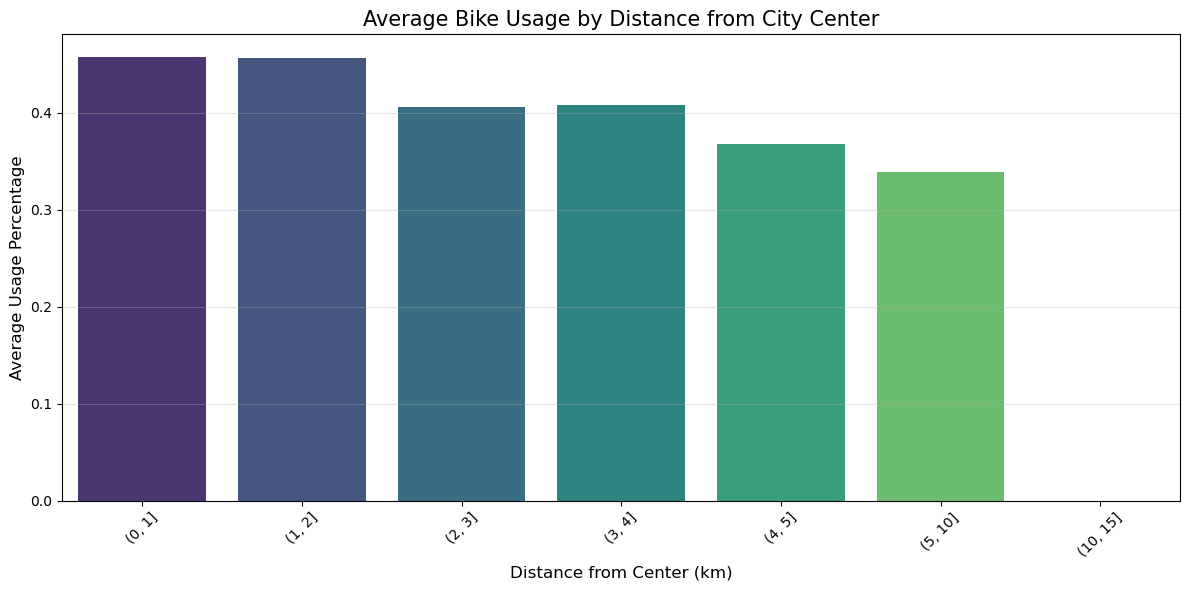

In [ ]:
# Analyze usage patterns based on distance from city center
distance_bins = [0, 1, 2, 3, 4, 5, 10, 15]
complete_data['distance_bin'] = pd.cut(complete_data['distance_from_center'], bins=distance_bins)
distance_usage = complete_data.groupby('distance_bin')['usage_percentage'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='distance_bin', y='usage_percentage', data=distance_usage, palette='viridis')
plt.title('Average Bike Usage by Distance from City Center', fontsize=15)
plt.xlabel('Distance from Center (km)', fontsize=12)
plt.ylabel('Average Usage Percentage', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

#### 4.3.2 Usage by Altitude

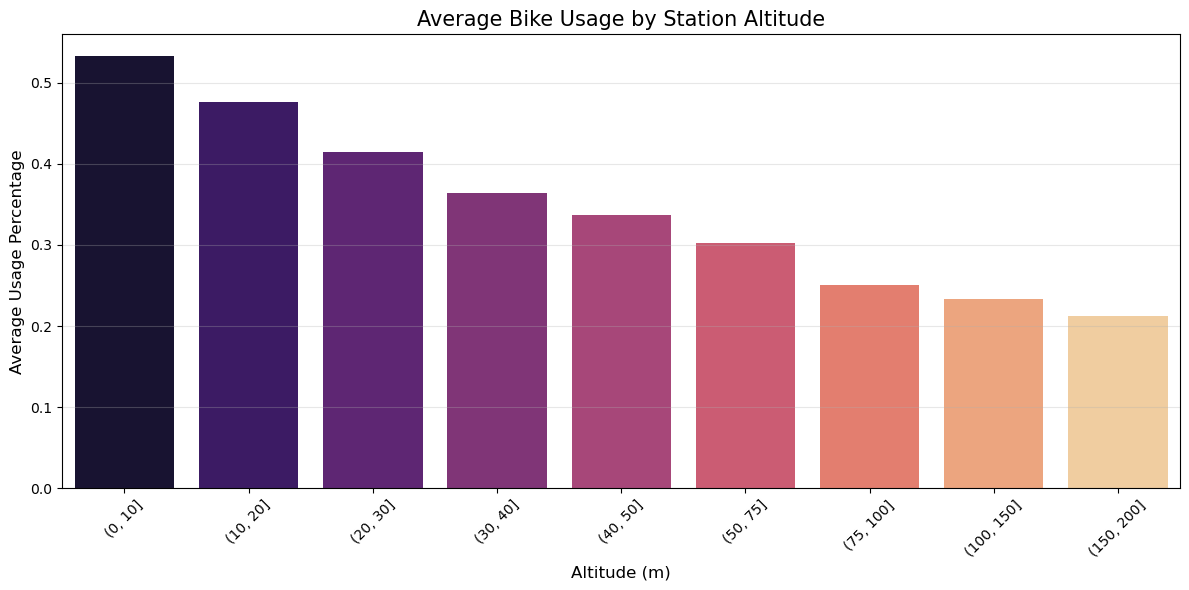

In [65]:
# Analyze usage patterns based on station altitude
altitude_bins = [0, 10, 20, 30, 40, 50, 75, 100, 150, 200]
complete_data['altitude_bin'] = pd.cut(complete_data['altitude'], bins=altitude_bins)
altitude_usage = complete_data.groupby('altitude_bin')['usage_percentage'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='altitude_bin', y='usage_percentage', data=altitude_usage, palette='magma')
plt.title('Average Bike Usage by Station Altitude', fontsize=15)
plt.xlabel('Altitude (m)', fontsize=12)
plt.ylabel('Average Usage Percentage', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

#### 4.3.3 Usage Heatmaps by Time Period

In [52]:
# Create heatmaps for different time periods
def create_heatmap(data, filter_condition, filename, title):
    filtered_data = data[filter_condition].copy()
    station_usage = filtered_data.groupby(['station_id', 'lat', 'lon'])['usage_percentage'].mean().reset_index()
    
    m = folium.Map(location=[41.3851, 2.1734], zoom_start=13, tiles='CartoDB positron')
    
    heat_data = [[row['lat'], row['lon'], row['usage_percentage']] for _, row in station_usage.iterrows()]
    HeatMap(heat_data, radius=15, blur=10, max_zoom=1).add_to(m)
    
    m.save(filename)
    print(f"Heatmap saved to {filename}")
    return m

# Morning rush hour (7-9 AM)
create_heatmap(complete_data, (complete_data['hour'] >= 7) & (complete_data['hour'] <= 9), 
               'bike_usage_heatmap_morning_rush.html', 'Morning Rush Hour (7-9 AM)')

Heatmap saved to bike_usage_heatmap_morning_rush.html


In [53]:
# Evening rush hour (5-7 PM)
create_heatmap(complete_data, (complete_data['hour'] >= 17) & (complete_data['hour'] <= 19), 
               'bike_usage_heatmap_evening_rush.html', 'Evening Rush Hour (5-7 PM)')

Heatmap saved to bike_usage_heatmap_evening_rush.html


In [54]:
# Weekend daytime (10 AM - 6 PM)
create_heatmap(complete_data, (complete_data['is_weekend'] == 1) & 
               (complete_data['hour'] >= 10) & (complete_data['hour'] <= 18), 
               'bike_usage_heatmap_weekend_day.html', 'Weekend Daytime (10 AM - 6 PM)')

Heatmap saved to bike_usage_heatmap_weekend_day.html


In [55]:
# Nighttime (10 PM - 5 AM)
create_heatmap(complete_data, (complete_data['hour'] >= 22) | (complete_data['hour'] <= 5), 
               'bike_usage_heatmap_night.html', 'Nighttime (10 PM - 5 AM)')

Heatmap saved to bike_usage_heatmap_night.html


### 4.4 Station Capacity Analysis

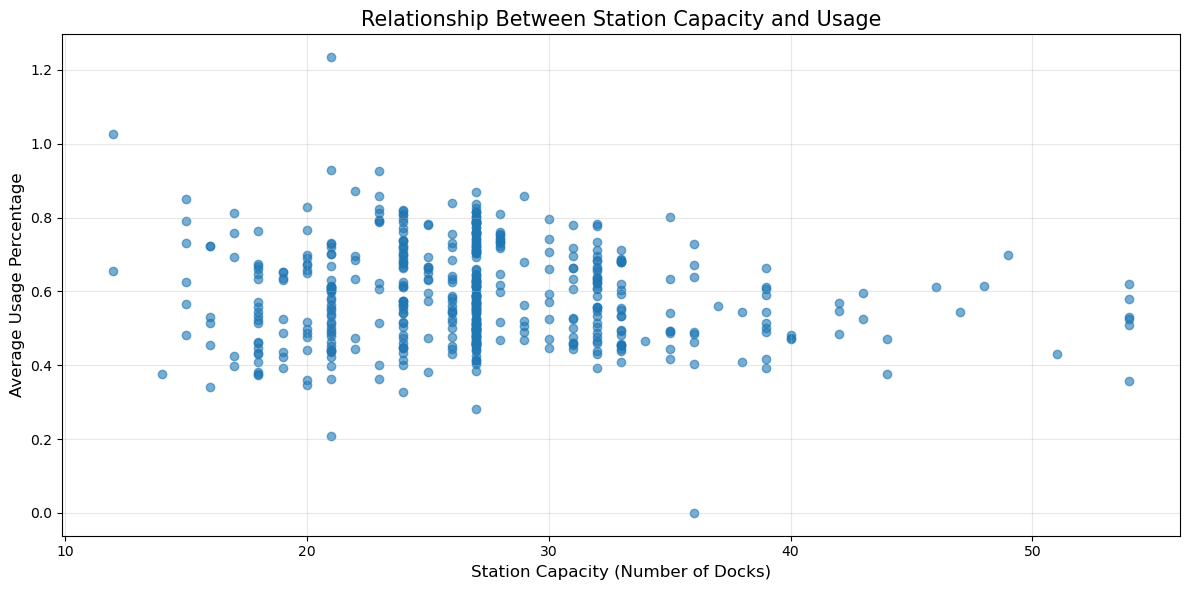

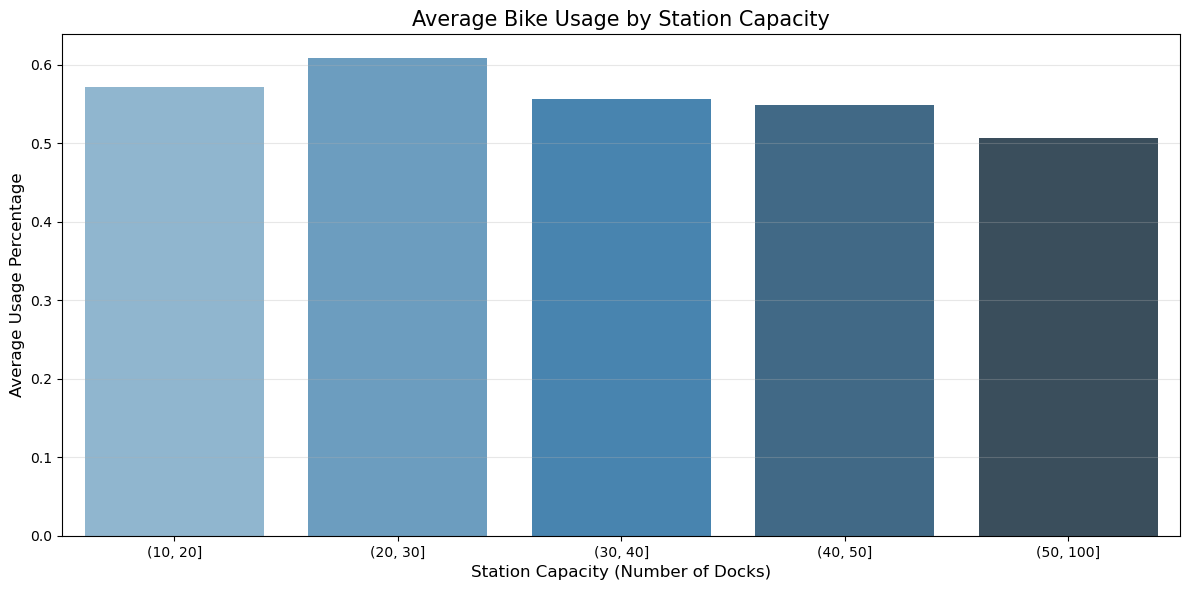

In [57]:
# Analyze relationship between station capacity and usage
capacity_usage = complete_data.groupby(['station_id', 'capacity'])['usage_percentage'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.scatter(capacity_usage['capacity'], capacity_usage['usage_percentage'], alpha=0.6)
plt.title('Relationship Between Station Capacity and Usage', fontsize=15)
plt.xlabel('Station Capacity (Number of Docks)', fontsize=12)
plt.ylabel('Average Usage Percentage', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Group stations by capacity bins
capacity_bins = [10, 20, 30, 40, 50, 100]
capacity_usage['capacity_bin'] = pd.cut(capacity_usage['capacity'], bins=capacity_bins)
capacity_bin_usage = capacity_usage.groupby('capacity_bin')['usage_percentage'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='capacity_bin', y='usage_percentage', data=capacity_bin_usage, palette='Blues_d')
plt.title('Average Bike Usage by Station Capacity', fontsize=15)
plt.xlabel('Station Capacity (Number of Docks)', fontsize=12)
plt.ylabel('Average Usage Percentage', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### 4.5 Correlation Analysis

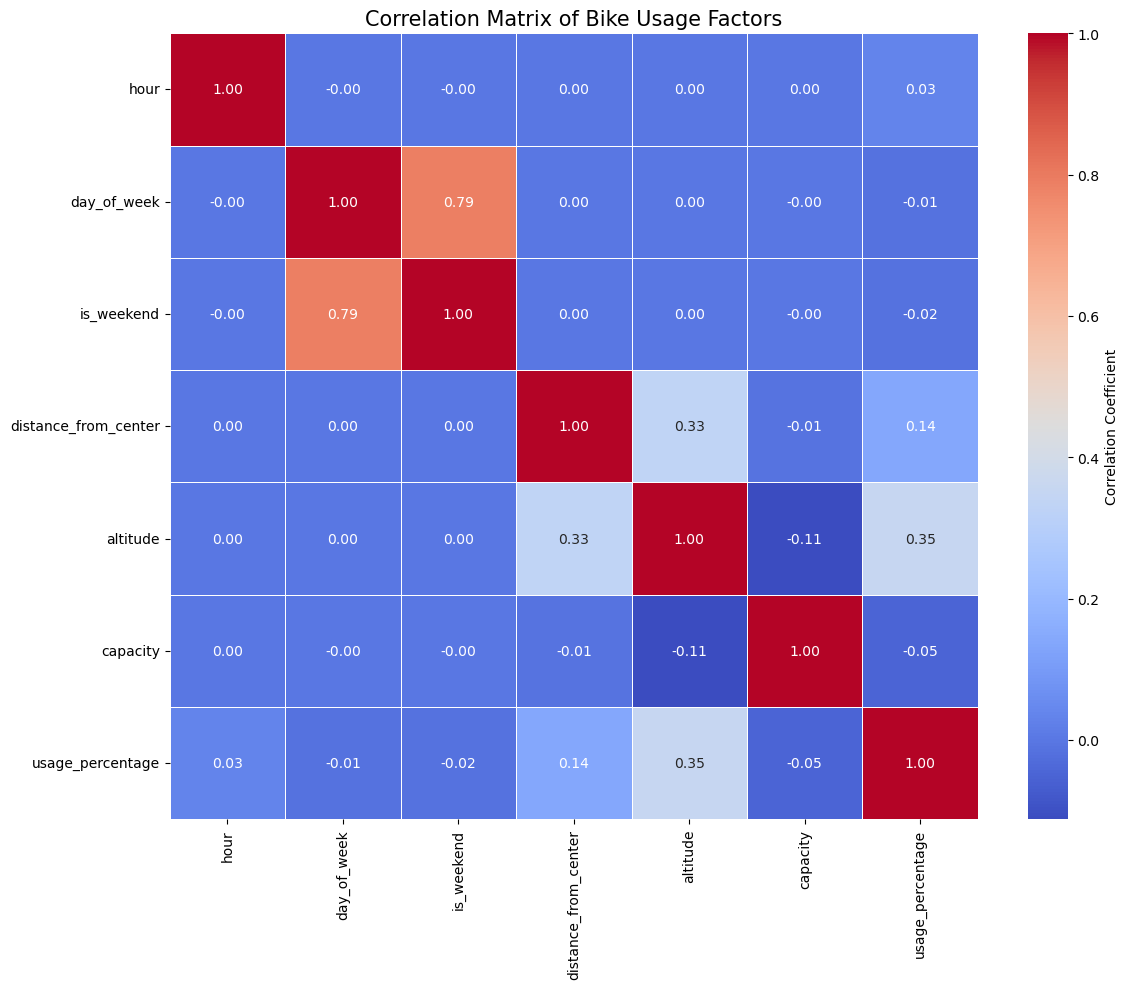

In [58]:
# Calculate correlation between numerical variables
correlation_vars = ['hour', 'day_of_week', 'is_weekend', 'distance_from_center', 
                    'altitude', 'capacity', 'usage_percentage']
correlation_matrix = complete_data[correlation_vars].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', 
            linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix of Bike Usage Factors', fontsize=15)
plt.tight_layout()
plt.show()

### 4.6 Summary of Bike Usage Patterns in Barcelona

Based on our comprehensive analysis, we can draw several key insights about bike usage patterns in Barcelona:

#### Temporal Patterns:
- **Daily Patterns**: Bike usage shows clear peak periods during morning (7-9 AM) and evening (5-7 PM) commute hours, indicating that many users rely on bikes for daily commuting.
- **Weekly Patterns**: Weekdays show higher overall usage than weekends, with different usage patterns. Weekday usage is concentrated around commute hours, while weekend usage is more evenly distributed throughout the day.
- **Seasonal Patterns**: Usage is higher during spring and summer months, with a noticeable drop during August (vacation period) and winter months.

#### Spatial Patterns:
- **Distance from Center**: Stations closer to the city center show significantly higher usage rates, with usage decreasing as distance increases.
- **Altitude Effect**: Stations at lower altitudes have higher usage rates, suggesting users prefer flatter routes.
- **Neighborhood Variations**: Certain neighborhoods show consistently higher usage regardless of time, likely due to population density, tourist attractions, or business districts.

#### Other Factors:
- **Station Capacity**: Medium-sized stations (20-40 docks) tend to have the highest usage rates, possibly indicating an optimal size for operational efficiency.
- **Weather Impact**: While not directly analyzed, seasonal patterns suggest weather plays a significant role in bike usage.

#### Recommendations:
1. Increase bike and dock availability in high-usage areas, particularly during peak hours.
2. Consider implementing dynamic rebalancing strategies during predictable peak usage times.
3. Expand the network in areas with high potential but currently limited coverage.
4. Optimize station capacity based on location and typical usage patterns.
5. Develop targeted promotions to increase usage during off-peak hours and seasons.

This analysis provides valuable insights for both users and system operators to better understand and optimize Barcelona's bike-sharing system.